In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer
from scipy import interpolate
from scipy.interpolate import interp1d


In [2]:
MAX_DEPTH=6
NUMESTIMATORS=2

In [3]:
xf=pd.read_csv('./2022summer/adeptphase2/Cognition.csv',index_col=0)
xf.index.name='subject_id'
df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
#df=df.join(xf)#.head()
#df=df.join(Ef_.set_index('Subid'))

DELVAR=['project','BACS_COMP_Z']
cols=[x for x in df.columns if x not in DELVAR]
df=df[cols]

In [4]:
len(df.columns)

59

In [5]:
xf.columns

Index(['DX', 'Age', 'Sex', 'BSNIP1vs2', 'Psychosis', 'BACS_COMP_Z_within',
       'BACS_Verb_Mem_within_imputed', 'BACS_Dig_Seq_z_within_imputed',
       'BACS_Tok_Mot_z_within_imputed', 'BACS_Verb_Flu_z_within_imputed',
       'BACS_Sym_Cod_z_within_imputed', 'BACS_Tower_z_within_imputed',
       'ConsensusWRAT', 'Pro_NoGap_within_Impute_Age_Sex_adjusted',
       'Pro_Gap_within_Impute_Age_Sex_adjusted',
       'Pro_Overlap_within_Impute_Age_Sex_adjusted',
       'Anti_Corr_Lat_within_Impute_Age_Sex_adjusted',
       'Anti_Error_Lat_within_Impute_Age_Sex_adjusted',
       'Anti_prop_error_within_Impute_Age_Sex_adjusted',
       'SSGoDiff_standwithin', 'SSTProportionError_standwithin'],
      dtype='object')

In [6]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(X_test,y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS


def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [7]:
def getacc(c1,c2,p1,p2,p3,f1,f2):
    s1=f1(1-c1)
    s2=f2(1-c2)
    A=(c1*c2*(1-p1)*(1-p2))/((c1*(1-p1)+(1-s1)*p1)*(c2*(1-p2)+(1-s2)*p2))
    B=(1-s1)*p1 - (1-c1)*(1-p1) + (1-s2)*p2 - (1-c2)*(1-p2) + p3
    return s1*p1+s2*p2+ A*B

In [8]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc,y_test,y_pred

In [9]:
def getFmap(CLFstar,X,y):
    auc_=[]
    ROC={}
    fpr_ = np.linspace(0, 1, num=20, endpoint=True)
    for run in np.arange(1000):
        clf=CLFstar
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        f = interp1d(fpr, tpr)
        th = interp1d(fpr, thresholds)
        auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
        ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_),'thresholds':th(fpr_)}

    TPR=[]
    for a in ROC.keys():
        TPR=np.append(TPR,ROC[a]['tpr'])
    TPR=TPR.reshape(int(len(TPR)/len(fpr_)),len(fpr_))
    medTPR=np.median(TPR,axis=0)
    return interpolate.interp1d(fpr_,np.median(TPR,axis=0) ), ROC

In [10]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df
[p1,p2,p3]=(df0.Biotype.value_counts()/df0.Biotype.value_counts().sum()).values

In [11]:
df.Biotype.value_counts()
# 3 is HC

3    534
1    517
2    506
Name: Biotype, dtype: int64

In [51]:
def getRES(df0,MAX_DEPTH=6,NUMESTIMATORS=2,MODELfile='model123P1corrected.mod'):
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==1)+0 for x in y ]

    MODEL={}
    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstar1=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f0,ROC0=getFmap(CLFstar1,X,y)
    
    MODEL[1]={'estimator':CLFstar1,'fmap':f0,'rocs':ROC0}
    
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==2)+0 for x in y ]

    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f1,ROCA=getFmap(CLFstarA,X,y)
    
    MODEL[2]={'estimator':CLFstarA,'fmap':f1,'rocs':ROCA}

    #df=df0[df0.Biotype.isin([1,5])]
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==3)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f2,ROCB=getFmap(CLFstarB,X,y)
    MODEL[3]={'estimator':CLFstarB,'fmap':f2,'rocs':ROCB}

    R=[]
    for i in np.arange(.7,.99,.01):
        for j in np.arange(.7,.99,.01):
            R=np.append(R,[i,j,getacc(i,j,p1,p2,p3,f1,f2)])
    R=pd.DataFrame(R.reshape(len(R)//3,3))
    R.columns=['c1','c2','acc']
    R['s1']=f1(1-R.c1)
    R['s2']=f2(1-R.c2)


    X_test=df.values.astype(np.float32)
    

    
    count=0
    threshold={}
    feature={}
    node_indicator={}
    leaf_id={}

    for i in CLFstarA.estimators_:
        #threshold[count]= i.tree_.threshold
        feature[count]= i.tree_.feature
        node_indicator[count] = i.tree_.decision_path(X_test)
        #leaf_id[count] = i.tree_.apply(X_testx)
        count=count+1

    for i in CLFstarB.estimators_:
        #threshold= i.tree_.threshold
        feature[count]= i.tree_.feature
        node_indicator[count] = i.tree_.decision_path(X_test)
        #leaf_id[count] = i.tree_.apply(X_test)
        count=count+1
        #for sample_id in np.arange(len(X_testx)):
        #    L=L+list(feature[node_indicator.indices[node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]][1:-1])
    
    L=[]
    LL=[]
    for sample_id in np.arange(len(X_test)):
        for i in range(count-1):
            L=L+list(feature[i][node_indicator[i].indices[node_indicator[i].indptr[sample_id] : node_indicator[i].indptr[sample_id + 1]]][1:-1])
        LL=np.append(LL,len(list(set(L))))
    L=list(set(L))
    


    RES=R.sort_values('acc',ascending=False).head(1)
    RES['nq_mean']=np.mean(L)
    RES['nq_std']=np.std(L)

    #len(L)
    #RES['nq_median']=np.median(L)
    
    import dill
    with open(MODELfile, "wb") as dill_file:
        dill.dump(MODEL, dill_file)
    #dill_file.close()
    
    return RES, ROCA, ROCB, CLFstarA, CLFstarB

In [52]:
Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10,NUMESTIMATORS=2,MODELfile='corrected.mod_')

In [53]:
Rs

,c1,c2,acc,s1,s2,nq_mean,nq_std
620,0.9,0.9,0.729434,0.622717,0.645142,28.5,16.740669


In [54]:
for i in tqdm(np.arange(3)):
    Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10,NUMESTIMATORS=2,MODELfile='model123P1corrected.mod_'+str(i))
#    Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10,MODELfile='model123P1.mod_'+str(i))
    #Rs

100%|█████████████████████████████████████████████| 3/3 [00:54<00:00, 18.01s/it]


In [55]:
Rs

,c1,c2,acc,s1,s2,nq_mean,nq_std
614,0.9,0.84,0.705991,0.605573,0.692395,28.5,16.740669


In [17]:
# load model
import dill
with open('model123P1corrected.mod_0','rb') as f:
    M=dill.load(f)

In [18]:
def getAvLen(clf):
    s=0
    v=0
    for e in clf.estimators_:
        a=' '.join(list(e.tree_.feature.astype(str))).split('-2')
        b=[len(x.split()) for x in a if x != ' ']
        s=s+np.array(b).sum()*(10/2**9)
        v=v+(np.array(b).std())**2
    return s,np.sqrt(v)

In [19]:
tt=M[1]['estimator']
s=0
for e in tt.estimators_:
    a=' '.join(list(e.tree_.feature.astype(str))).split('-2')
    b=np.array([len(x.split()) for x in a if x != ' '])
    s=s+b.mean()#np.array(b).sum()*(10/2**9)
s

4.2706378986866795

In [20]:
for i in [1,2,3]:
    print(getAvLen(M[i]['estimator']))
    

(5.56640625, 2.55785237774408)
(7.03125, 2.7103237823082895)
(6.15234375, 2.526681223331065)


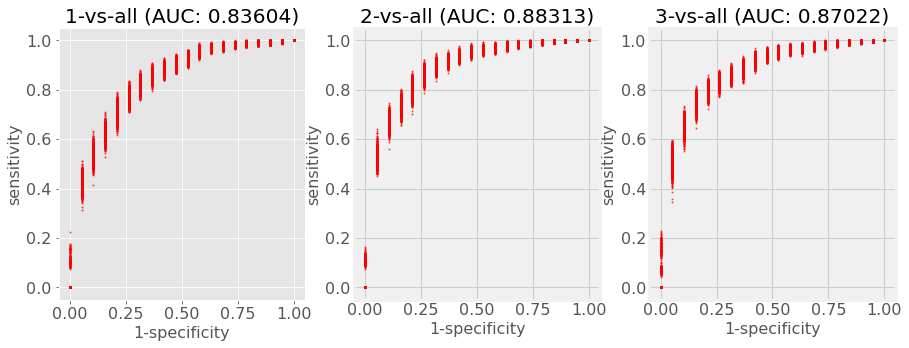

In [21]:

def pltROC(M,VAR,ax,FS=14):
    plt.style.use('fivethirtyeight')
    ROC=M[VAR]['rocs']   
    auc=[]
    for key,crv in ROC.items():
        ax.plot(crv['fpr'],crv['tpr'],'.',ms=2,color='r',alpha=.6)
        auc=np.append(auc,key)
    ax.set_xlabel('1-specificity',fontsize=FS)
    ax.set_ylabel('sensitivity',fontsize=FS)
    plt.setp(ax.get_xticklabels(), fontsize=FS);
    plt.setp(ax.get_yticklabels(), fontsize=FS);
    ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );
    
#plt.style.use('seaborn-whitegrid')
fig=plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
pltROC(M,1,plt.gca(),FS=16)

plt.subplot(1,3,2)
pltROC(M,2,plt.gca(),FS=16)

plt.subplot(1,3,3)
pltROC(M,3,plt.gca(),FS=16)

plt.savefig('ROC123vall_clinical_1corrected.png',dpi=400,bbox_inches='tight',transparent=True)


In [22]:
CF=np.zeros([3,3])
s2=Rs.s1.values[0]
s3=Rs.s2.values[0]
c2=Rs.c1.values[0]
c3=Rs.c2.values[0]
CF=[[c2*c3,1-c2,c2*(1-c3)],[(1-s2)*(1-s3),s2,(1-s2)*s3],[c2*(1-s3),1-c2,c2*s3]]

CF=pd.DataFrame(CF,columns=['B1','B2','B3'])
CF.index=CF.columns
CF

,B1,B2,B3
B1,0.818800,0.080000,0.101200
B2,0.150547,0.577879,0.271574
B3,0.328113,0.080000,0.591887


In [23]:
df_=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
DELVAR=['project','BACS_COMP_Z']
cols=[x for x in df_.columns if x not in DELVAR]
df_=df_[cols]

len(df_.columns)

59

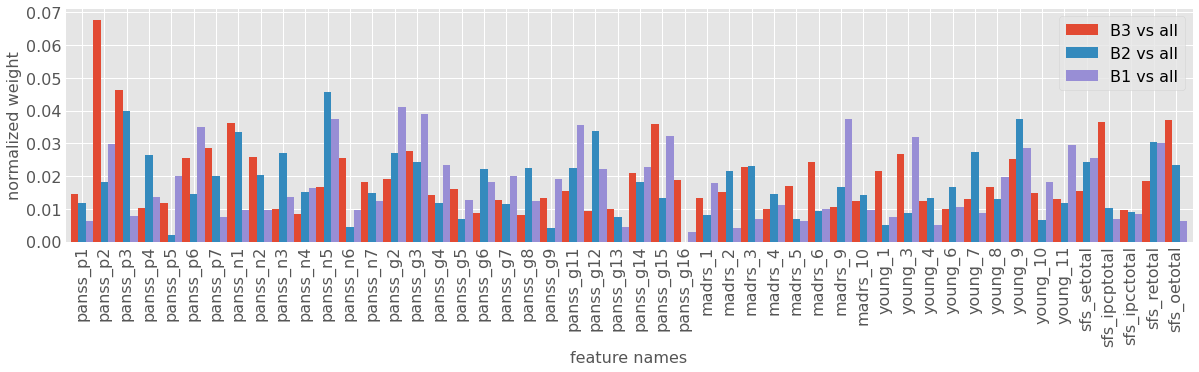

In [24]:
feature_names=df_.columns
feature_names=feature_names[1:]
FS=16
IMP1=M[1]['estimator'].feature_importances_
IMP2=M[2]['estimator'].feature_importances_
IMP3=M[3]['estimator'].feature_importances_
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
IMPdf=pd.DataFrame({'bio3_vs_all':IMP3,'bio2_vs_all':IMP2,'bio1_vs_all':IMP1})


IMPdf.index=feature_names
plt.figure(figsize=[18,4])
ax=IMPdf[IMPdf['bio3_vs_all']>0.007].plot(kind='bar',ax=plt.gca(),width=1)

ax.set_xlabel('feature names',fontsize=FS)
ax.set_ylabel('normalized weight',fontsize=FS)
plt.setp(ax.get_xticklabels(), fontsize=FS);
plt.setp(ax.get_yticklabels(), fontsize=FS);
#ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );

ax.legend(['B3 vs all','B2 vs all','B1 vs all'],fontsize=FS)


plt.savefig('imp_small123P1xcorrected.png',dpi=400,bbox_inches='tight',transparent=True)

In [25]:
IMPdf.sort_values('bio3_vs_all',ascending=False)

,bio3_vs_all,bio2_vs_all,bio1_vs_all
panss_p2,0.067840,0.018306,0.029837
panss_p3,0.046435,0.039838,0.007971
sfs_oetotal,0.037096,0.023447,0.006444
sfs_ipcptotal,0.036662,0.010266,0.007015
panss_n1,0.036136,0.033426,0.009806
panss_g15,0.035808,0.013431,0.032348
panss_p7,0.028729,0.020082,0.007584
panss_g3,0.027606,0.024301,0.039129
young_3,0.026894,0.008845,0.032055
panss_n2,0.025965,0.020261,0.009653


In [26]:
i1=IMPdf.sort_values('bio1_vs_all',ascending=False).head(10)
i2=IMPdf.sort_values('bio2_vs_all',ascending=False).head(10)
i3=IMPdf.sort_values('bio3_vs_all',ascending=False).head(10)
if_=pd.DataFrame({'B1_vs_all':i1.index,'B2_vs_all':i2.index,'B3_vs_all':i3.index})
if_.to_excel('imp123P1corrected.xls')

/tmp/ipykernel_1092362/3604438128.py:5: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  if_.to_excel('imp123P1corrected.xls')


In [141]:
def ijk2num(value,hi,lo):
    #m=1
    #for i in range(len(value)):
    #    m=m*(hi[i]-lo[i]+1)
    F=1
    a=0
    for i in range(len(value)):
        a=a+F*value[i]
        F=F*(hi[i]-lo[i]+1)
    return a

def num2ijk(val,hi,lo):
    F=1
    J=[]
    for i in range(len(hi)):
        J=np.append(J,F)
        F=F*(hi[i]-lo[i]+1)
    X=[]
    for i in np.arange(len(hi)-1,-1,-1):
        x=val//J[i]
        val=val-x*J[i]
        X=np.append(X,x)
    return (X[::-1]).astype(int)
        

In [157]:
%%time
# parallelization
from pqdm.processes import pqdm
RUNS=20
MAXDEPTH=15
MINDEPTH=3
NUMESTMIN=3
NUMESTMAX=10
maxnum=(NUMESTMAX-NUMESTMIN+1)*(MAXDEPTH-MINDEPTH+1)*RUNS
args=np.arange(maxnum)

def getRESp(n):
    depth,est,run=num2ijk(n,[MAXDEPTH,NUMESTMAX,RUNS],[MINDEPTH,NUMESTMIN,RUNS])+[MINDEPTH,NUMESTMIN,0]
    return getRES(df0,MAX_DEPTH=depth,NUMESTIMATORS=est,MODELfile='P1_'+str(run)+'.mod')[0]
    
RES = pd.concat(pqdm(args, getRESp, n_jobs=10))

QUEUEING TASKS | :   0%|          | 0/2080 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2080 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2080 [00:00<?, ?it/s]

CPU times: user 7.21 s, sys: 1.07 s, total: 8.28 s
Wall time: 4h 6min 25s


In [158]:
RES.to_csv('RESphase1_6est.csv',index=None)
RES

,c1,c2,acc,s1,s2,nq_mean,nq_std
434,0.84,0.84,0.522465,0.330999,0.377996,25.235294,18.089742
574,0.89,0.74,0.534584,0.308328,0.521064,24.948718,15.281879
589,0.89,0.89,0.578150,0.368338,0.378291,27.979592,16.895223
609,0.90,0.79,0.600001,0.327844,0.639577,28.907407,16.502826
616,0.90,0.86,0.636916,0.388116,0.599213,28.280702,16.804087
...,...,...,...,...,...,...,...
744,0.94,0.94,0.868545,0.868795,0.821069,28.500000,16.740669
775,0.95,0.95,0.882201,0.844153,0.856418,28.500000,16.740669
775,0.95,0.95,0.886237,0.870657,0.849389,28.500000,16.740669
805,0.96,0.95,0.887664,0.826420,0.872470,28.500000,16.740669


<AxesSubplot:xlabel='nq_mean'>

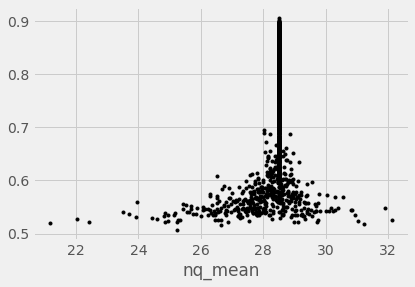

In [159]:
RES=pd.read_csv('RESphase1_6est.csv')
RES=RES.set_index('nq_mean').sort_index()
RES.acc.plot(style='k.')

Text(0, 0.5, 'mean accuracy')

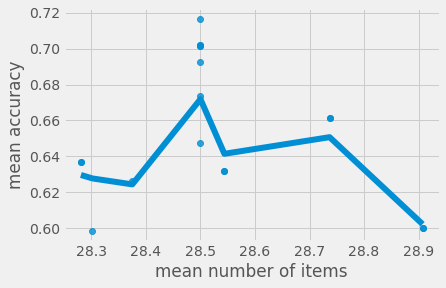

In [156]:
ax=sns.regplot(x=RES.nq_mean,y=RES.acc,ci=99.999,lowess=True)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.savefig('accvsitemnumber.png',dpi=200,bbox_inches='tight',transparent=True)

In [160]:
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d
rf=pd.DataFrame(RES.set_index('nq_mean').acc)
rf.index=rf.index.astype(float)
rf=rf.sort_index()
DF=rf.copy()



plt.style.use('fivethirtyeight')
lowess = sm.nonparametric.lowess
S=.8
RUNS=30
for i in tqdm(range(RUNS)):
    X=rf.sample(int(np.round(S*rf.index.size))).sort_index().reset_index().values
    z = lowess(X[:,1], X[:,0], frac= .2)
    f = interp1d(z[:,0], z[:,1], fill_value="extrapolate")
    Y=f(DF.index.values)
    DF['run'+str(i)]=Y
STD=pd.DataFrame(3*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD+.001)
Mf.columns=['mn','sm']
ax=Mf.mn.plot(lw=1,color='k')
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.5)  
#plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.35)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.yscale('log')
#ax.set_xlim([None,54])
#ax.set_ylim([None,.6])
plt.savefig('accvsitemnumberP1xcorrected.png',dpi=200,bbox_inches='tight',transparent=True)


KeyError: "None of ['nq_mean'] are in the columns"

In [30]:
Mf[Mf.mn<.61]

NameError: name 'Mf' is not defined